In [30]:
import os
from pyrsgis import raster
from sklearn import cluster
from osgeo import gdal
import geopandas as gdp
import pandas as pd
import numpy as np
import rasterio as rio
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt
from glob import glob
from rasterio.plot import show
import pandas as pd
import cv2

In [12]:
southerAus = 'LC08_L1TP_090083_20191215_20191226_01_T1/LC08_20191215_1226_LayersStacked_ALL.tif'
fire_Binary = 'LC08_L1TP_090083_20191215_20191226_01_T1_NEW/min_distance_fire_nonfire.tif'
eastAus = 'LC08_L1TP_090082_20191231_20200111_01_T1/LC08_20191231_20200111_01_T1_Stacked.tif'

# Read the rasters as array

ds7, featuresSouthAus = raster.read(southerAus, bands='all')
ds6, labelsAus = raster.read(fire_Binary, bands=1)
ds5, featuresEastAus = raster.read(eastAus, bands='all')

In [13]:
print("Fire b7 image shape: ", featuresSouthAus.shape)
print("Fire b6 image shape: ", labelsAus.shape)
print("Fire b5 image shape: ", featuresEastAus.shape)

Fire b7 image shape:  (7, 7691, 7621)
Fire b6 image shape:  (7691, 7621)
Fire b5 image shape:  (7, 7701, 7641)


In [14]:
from pyrsgis.convert import changeDimension

featuresSouthAus = changeDimension(featuresSouthAus)
labelsAus  = changeDimension(labelsAus)
featuresEastAus = changeDimension(featuresEastAus)
nBands = featuresSouthAus.shape[1]
labelsAus= (labelsAus == 1).astype(int)

print("Souther Aus multispectral image shape: ", featuresSouthAus.shape)
print("Southern Aus Fire/nonFire binary shape: ", labelsAus.shape)
print("Victoria multispectral image shape: ", featuresEastAus.shape)

Souther Aus multispectral image shape:  (58613111, 7)
Southern Aus Fire/nonFire binary shape:  (58613111,)
Victoria multispectral image shape:  (58843341, 7)


In [17]:
from sklearn.model_selection import train_test_split

                              #X (Indepent Varibles/Data)  #y(Dependent/Labels (Fire/NonFire))
xTrain, xTest, yTrain, yTest = train_test_split(featuresSouthAus, labelsAus, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

(35167866, 7)
(35167866,)
(23445245, 7)
(23445245,)


In [18]:
# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))
featuresEastAus = featuresEastAus.reshape((featuresEastAus.shape[0], 1, featuresEastAus.shape[1]))

# Print the shape of reshaped data
print(xTrain.shape, xTest.shape, featuresEastAus.shape)



(35167866, 1, 7) (23445245, 1, 7) (58843341, 1, 7)


In [19]:
from tensorflow import keras

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=2)

Train on 35167866 samples
Epoch 1/2
35167866/35167866 [==============================] - 1023s 29us/sample - loss: 0.0053 - accuracy: 0.9999
Epoch 2/2
35167866/35167866 [==============================] - 895s 25us/sample - loss: 0.0023 - accuracy: 0.9999


In [20]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict for test data 
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

print("Confusion matrix: for 14 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

Confusion matrix: for 14 nodes
 [[23438087     2235]
 [      24     4899]]

P-Score: 0.687, R-Score: 0.995


In [26]:
landsat_path = glob("LC08_L1TP_090082_20191231_20200111_01_T1/LC08_L1TP_090082_20191231_20200111_01_T1_B*.TIF")
landsat_path.sort()
array_stack, meta_data = es.stack(landsat_path)

print(len(landsat_path))

7


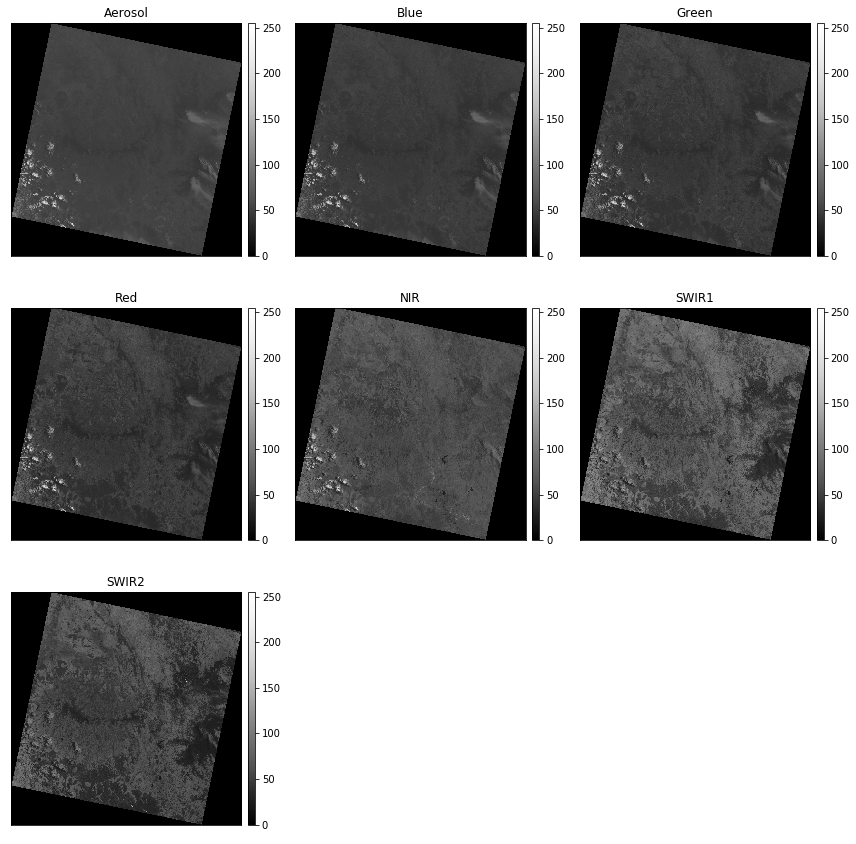

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C90279DF88>,
      dtype=object)

In [27]:
title = ['Aerosol' , 'Blue' , 'Green' , 'Red' , 'NIR' , 'SWIR1' , 'SWIR2']


ep.plot_bands(array_stack,
              title=title)

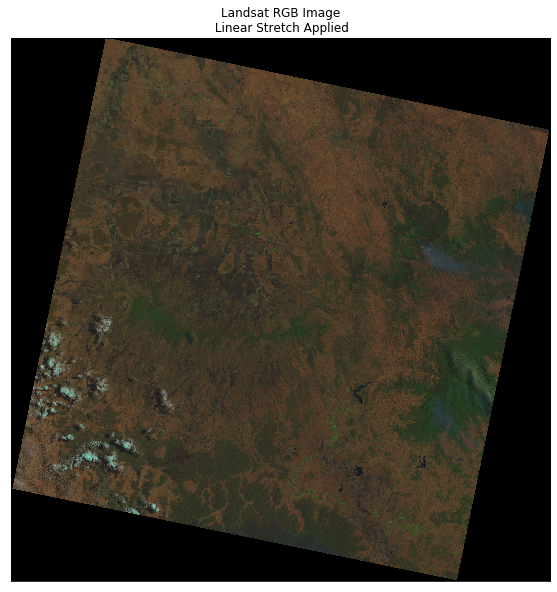

In [28]:
# Adjust the amount of linear stretch to futher brighten the image

ep.plot_rgb(array_stack,
            rgb=[5, 4, 2],
            title="Landsat RGB Image\n Linear Stretch Applied")
plt.show()

In [24]:
predicted = model.predict(featuresEastAus)
predicted = predicted[:,1]
#Export raster
prediction = np.reshape(predicted, (ds5.RasterYSize, ds5.RasterXSize))
outFile = 'Eastern Australia Fire Prediction.tif'
raster.export(prediction, ds5, filename=outFile, dtype='float')

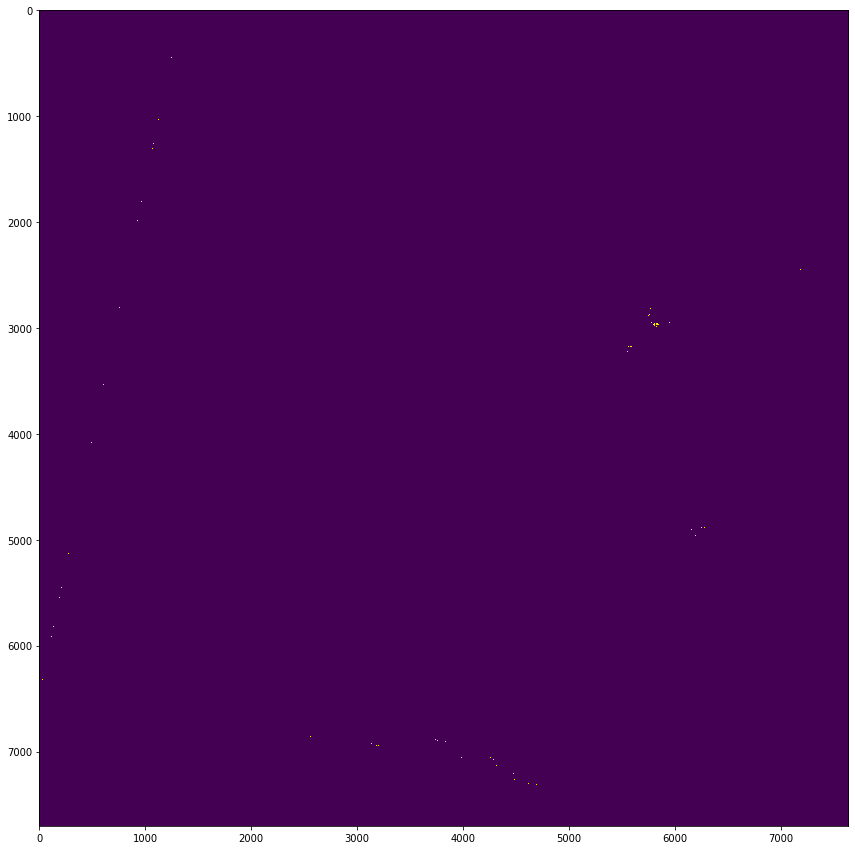

In [41]:
# Read File Raster Data as Array using Gdal
img_file = "Eastern Australia Fire Prediction.tif"
gtif = gdal.Open(img_file)
georaster = gtif.ReadAsArray()

 # Plot image using matplotlib
plt.figure(figsize=(15,15))
plt.imshow(georaster)